# Homework

You need to train the model and get score as big as you can

Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

### Prepare part

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

%matplotlib inline

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O data.tar.gz "{download_url}"
!tar -xf data.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.appl

In [3]:
DEVICE = 'cuda' # also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = 'ml_trains_data'
LOADER_WORKERS = 2

In [26]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
            self._classes = len(labels)
        else:
            labels = {}  # Если метки не читаются, оставляем пустой словарь
            self._classes = 0
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []
        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        feats = self._feats(waveform)[0]
        return (feats, self._labels[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes


def collate_fn(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

### Feats part

In [27]:
# Try to use LogMelSpectrogram or MFCC to achive better score
class LogMelSpectrogram(nn.Module):
    pass

# FBANK 40 by default, but you can choose something else
FEATS = 40
transform = torchaudio.transforms.MelSpectrogram(n_mels=FEATS)
trainset = Dataset('train', '/content/ml_trains_data', transform)
testset = Dataset('eval', '/content/ml_trains_data', transform, read_labels=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [6]:
# Get list of pairs (target_class, predicted_class)
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
    C = 1/ classes
    sum_glav = 0

    for i in range(0, classes):
        sum_1 = 0
        sum_2 = 0
        for b in range(len(items)):
            if items[b][0] == i:
                sum_2 += 1
                if items[b][0] == items[b][1]:
                    sum_1 += 1
        if sum_2 > 0:
            sum_glav += sum_1 / sum_2
    BAcc =C * sum_glav
    return BAcc

    # <YOUR CODE IS HERE>

In [7]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

### Train part
Train some model with as big balanced accuracy as you can

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task. For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- Watch to overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Try different features (mel-spec, log-mel-spec, mfcc)

In [11]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 128,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
        torch.cuda.empty_cache()
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    batch_size: int = 128,
    epochs: int = 12,
):
    train_data, val_data = torch.utils.data.random_split(trainset, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size)
        val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')
        torch.cuda.empty_cache()

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        super(Model, self).__init__()
        # Свёрточные слои
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)  # (1, 40, 801) -> (64, 40, 801)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)  # Уменьшаем размерность по времени (ширина)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1)  # (64, 40, 801) -> (128, 40, 801)

        # Полносвязный слой
        self.fc1 = nn.Linear(128 * 10 * 200, 256)  # Это будет пересчитано после сверток
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(256, out_dim)

    def forward(self, X):
        # input: [batch_size, IN_FEATURES, TIME]
        # output: [batch_size, N_CLASSES]

        x = X.unsqueeze(1)
          # Добавляем размерность канала (из (batch_size, 40, 801) -> (batch_size, 1, 40, 801))

        # Свёртки и пуллинг
        x = self.pool(F.relu(self.conv1(x)))  # После первой свёртки размерность (batch_size, 64, 40, 801)
        x = self.pool(F.relu(self.conv2(x)))  # После второй свёртки размерность (batch_size, 128, 10, 200)

        # Переводим тензор в вектор, адаптируя размер  # Flatten the tensor, excluding the batch dimension

        # Пропускаем через полносвязный слой
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # (batch_size, n_classes)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self, in_dim=40, out_dim=10, n_heads=4, n_layers=2, cnn_out_channels=128):
        super(Model, self).__init__()

        # CNN: 2 блока, каждый из которых содержит 3 слоя свертки
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=3, padding=1)  # (1, 40, 801) -> (64, 40, 801)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=3, padding=1)  # (64, 40, 801) -> (128, 40, 801)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=cnn_out_channels, kernel_size=3, stride=3, padding=1)  # (128, 40, 801) -> (cnn_out_channels, 10, 200)

        # BatchNorm и Dropout для CNN
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(cnn_out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_cnn = nn.Dropout(0.3)

        # Преобразование размерности после сверток
        self.flattened_size = cnn_out_channels * 10 * 200  # Будет вычислено после пуллинга и свертки

        # Трансформер: 12 слоёв с 4 головами внимания
        self.encoder_layers = nn.TransformerEncoderLayer(
            d_model=self.flattened_size, nhead=n_heads, dim_feedforward=1024, dropout=0.4
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layers, num_layers=n_layers)

        # Полносвязный слой для классификации
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, out_dim)
        self.dropout_fc = nn.Dropout(0.4)

    def forward(self, X):
        # input: [batch_size, FEATS, TIME] -> (batch_size, 40, 801)

        # 1. Применяем CNN блоки
        x = X.unsqueeze(1)  # Добавляем размерность канала: (batch_size, 1, FEATS, TIME)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (batch_size, 64, 40, 801)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (batch_size, 128, 40, 801)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # (batch_size, cnn_out_channels, 10, 200)

        # Применяем Dropout после CNN
        x = self.dropout_cnn(x)

        # 2. Flatten тензор для подачи в трансформер
        x = x.view(x.size(0), -1)  # (batch_size, cnn_out_channels * 10 * 200)

        # 3. Применяем трансформер
        x = self.transformer(x)  # (batch_size, flattened_size)

        # 4. Полносвязные слои для классификации
        x = F.relu(self.fc1(x))  # (batch_size, 256)
        x = self.dropout_fc(x)  # Dropout
        x = self.fc2(x)  # (batch_size, out_dim)

        return x


In [ ]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

<ipython-input-9-91324fc5889e>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


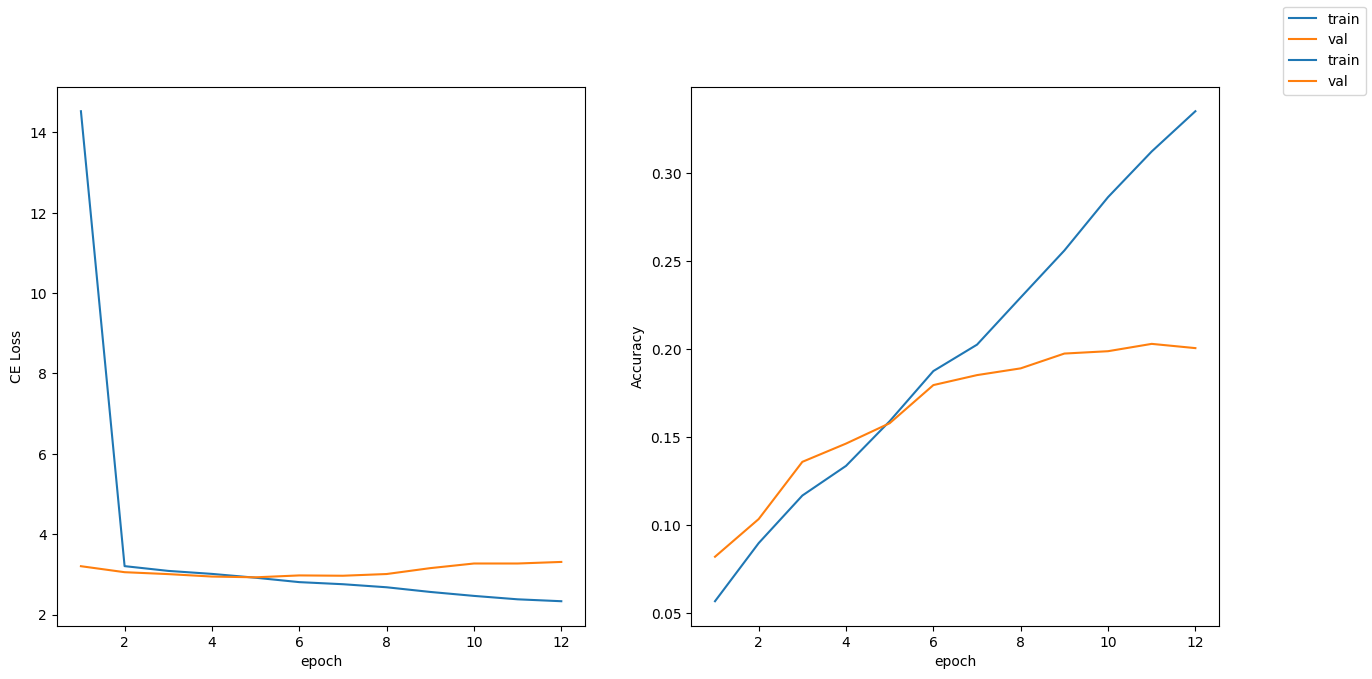

Epoch 12.
Train loss 2.330664931761252. Train accuracy 0.33522224866990846.
Test loss 3.308451073510306. Test accuracy 0.20069610077006192


In [13]:
model = Model().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train(model, opt)

### Prediction part

Prepare result file and send it to Yandex.Contest

In [39]:
import pandas as pd
import torch
from tqdm import tqdm

result = []  # Список для хранения результатов

# Загрузка названий видео из eval файла
eval_data = pd.read_csv('/content/ml_trains_data/eval.tsv', sep='\t')  # Замените путь на правильный
ytids = eval_data['YTID'].values  # Массив с идентификаторами видео

# Переводим модель в режим оценки
model.eval()

# Считаем, что test_loader уже загружает данные
with torch.no_grad():  # Отключаем вычисление градиентов
    batch_idx = 0  # Индекс для отслеживания текущего батча в ytid
    for feats, _ in tqdm(test_loader):  # Перебираем батчи данных
        feats = feats.to(DEVICE)  # Перемещаем данные на нужное устройство (GPU или CPU)

        # Прогоняем данные через модель
        pred = model(feats)  # Получаем предсказания

        # Находим индекс наиболее вероятного класса
        predict = torch.argmax(pred, dim=1).cpu().numpy()  # Преобразуем в numpy массив

        # Добавляем результаты в список, используя ytid из eval_data
        batch_size = feats.size(0)  # Получаем размер текущего батча
        for i in range(batch_size):  # Перебираем текущий батч
            result.append((ytids[batch_idx + i], trainset._idx_to_label[predict[i]]))  # Добавляем название видео и метку

        # Обновляем индекс батча
        batch_idx += batch_size

# Преобразуем результат в DataFrame и сохраняем в файл
df = pd.DataFrame(result, columns=['YTID', 'label'])
df.to_csv('result.tsv', sep='\t', index=False)


100%|██████████| 45/45 [00:23<00:00,  1.93it/s]
